In [50]:
import catboost as cb
import pandas as pd
from tqdm import tqdm

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, roc_curve

import shap

In [57]:
# df = pd.read_csv('../data/preprocessed/train_breast_cancer.csv')
# test_df = pd.read_csv('../data/preprocessed/test_breast_cancer.csv')

# target_name = 'diagnosis'
# cat_features = []
# num_features = [c for c in df.columns if c != target_name and c != 'id']
# true_class = 'benign'
# false_class = 'malignant'

df = pd.read_csv('../data/preprocessed/train_diabetes.csv')
test_df = pd.read_csv('../data/preprocessed/test_diabetes.csv')

target_name = 'diabetes'
num_features = ['HbA1c_level','bmi','age','blood_glucose_level']
cat_features = ['gender', 'hypertension', 'heart_disease', 'smoking_history']
true_class = 1
false_class = 0

input_features = num_features + cat_features

In [58]:
df[target_name] = df[target_name].replace({true_class: 1, false_class: 0})
test_df[target_name] = test_df[target_name].replace({true_class: 1, false_class: 0})

In [59]:
kf = StratifiedKFold(n_splits=5)
results_df = []
for i, (train_index, val_index) in tqdm(enumerate(kf.split(df[input_features], df[target_name]))):
    train_df = df.loc[train_index]
    val_df = df.loc[val_index]

    #Model training
    model = cb.CatBoostClassifier(
        learning_rate=0.1, # [1e-3, 0.99]
        n_estimators=500, # [50, 1000]
        random_state=34, #constant
        depth=4, # [4, 8]
        l2_leaf_reg=2, #[0, 100]
        loss_function='Logloss',
        min_data_in_leaf=3, #[0, 50]
        cat_features=cat_features,
        task_type='CPU'
    )
    model.fit(
        train_df[input_features],
        train_df[target_name],
        eval_set=(
            val_df[input_features],
            val_df[target_name],
        ),
        verbose=0,
        plot=True,
        early_stopping_rounds=100,
    )
    
    res = {
        'Fold': i,
        'Train score': model.best_score_['learn']['Logloss'],
        'Val score': model.best_score_['validation']['Logloss'],
        'model': model,
        'train_index': train_index,
        'val_index': val_index
    }
    results_df.append(res)
results_df = pd.DataFrame(results_df)
    

0it [00:00, ?it/s]

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

1it [00:11, 11.65s/it]

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2it [00:25, 12.86s/it]

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

3it [00:38, 12.79s/it]

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

4it [00:55, 14.50s/it]

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

5it [01:13, 14.69s/it]


In [60]:
best_model_idx = results_df['Val score'].argmin()
print(f'Best Cross-Validation split: {best_model_idx}')
best_model = results_df.loc[best_model_idx, 'model']
train_index = results_df.loc[best_model_idx, 'train_index']
val_index = results_df.loc[best_model_idx, 'val_index']

Best Cross-Validation split: 0


In [61]:
test_df[f'pred:{target_name}'] = best_model.predict(test_df[best_model.feature_names_])
df[f'pred:{target_name}'] = best_model.predict(df[best_model.feature_names_])

In [62]:
summary_df = []
for df_name, s_df in zip(['train', 'val', 'test'], [df.loc[train_index], df.loc[val_index], test_df]):
    TP = sum((s_df[f'pred:{target_name}'] == 1) & (s_df[target_name] == 1))
    TN = sum((s_df[f'pred:{target_name}'] == 0) & (s_df[target_name] == 0))
    FP = sum((s_df[f'pred:{target_name}'] == 1) & (s_df[target_name] == 0))
    FN = sum((s_df[f'pred:{target_name}'] == 0) & (s_df[target_name] == 1))

    res = {
        'data_type': df_name,
        'precision': TP / (TP + FP),
        'recall': TP / (TP + FN),
        'accuracy': (TP + TN) / (TP + TN + FP + FN),
    }
    res['f_score'] = 2 * res['precision'] * res['recall'] / (res['precision'] + res['recall'])
    res['TP'], res['TN'], res['FP'], res['FN']= TP, TN, FP, FN
    # res['support:0'] = sum(s_df[target_name] == 0)
    # res['support:1'] = sum(s_df[target_name] == 1)
    
    summary_df.append(res)
summary_df = pd.DataFrame(summary_df)
summary_df


,data_type,precision,recall,accuracy,f_score,TP,TN,FP,FN
0,train,0.987895,0.690074,0.972938,0.812554,3754,58514,46,1686
1,val,0.976434,0.700735,0.973125,0.815925,953,14617,23,407
2,test,0.969597,0.694118,0.972150,0.809050,1180,18263,37,520


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


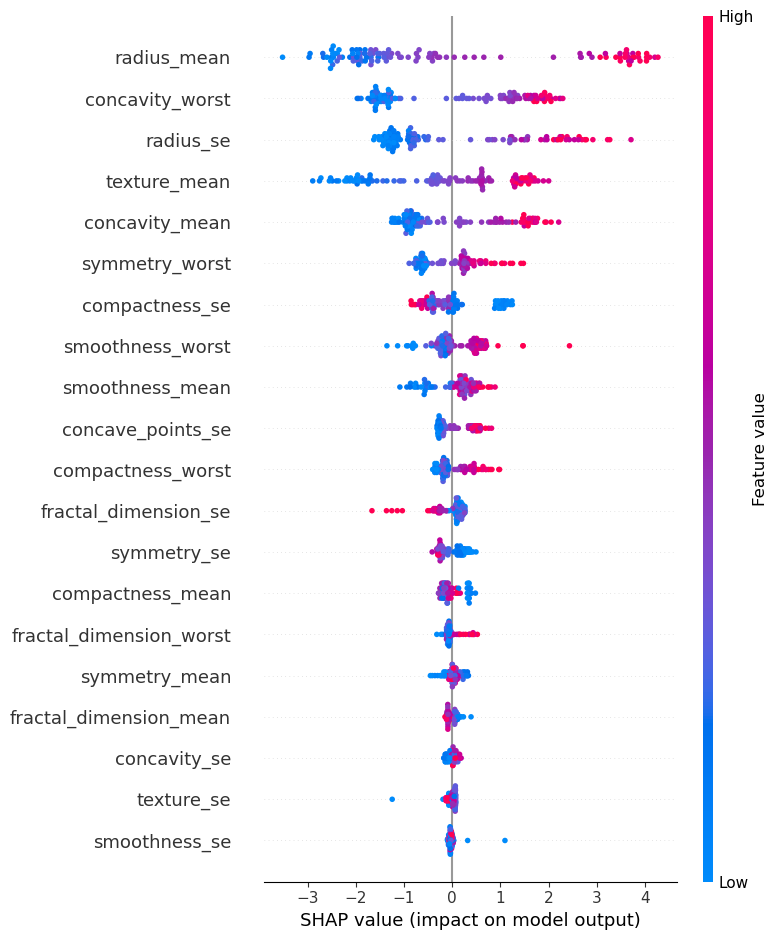

In [33]:
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(test_df[input_features])
shap.summary_plot(shap_values, test_df[input_features])

In [34]:
fi_df = pd.DataFrame(zip(best_model.feature_names_, best_model.feature_importances_), columns=['feature', 'feature_importance'])
fi_df.sort_values('feature_importance', ascending=False)

,feature,feature_importance
0,radius_mean,22.562650
17,concavity_worst,13.670273
7,radius_se,10.453353
1,texture_mean,9.801595
4,concavity_mean,7.567683
2,smoothness_mean,6.235076
18,symmetry_worst,5.012707
15,smoothness_worst,4.641584
10,compactness_se,3.923510
14,fractal_dimension_se,2.739267
